<h1> Weather Classification </h1>

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay, auc, ConfusionMatrixDisplay, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, classification_report, accuracy_score, precision_recall_fscore_support


from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


In [2]:
path ="../IDMT-Traffic/datasets/df_main_encoded_only.csv"
df = pd.read_csv(path)
df.drop(columns=["Unnamed: 0", "file", "is_background_encoded"] ,inplace=True)

In [3]:
correlation_matrix = df.corr()

In [4]:
# ranked correlation by classification 
highest_speed = correlation_matrix["speed_kmh_encoded"].abs().sort_values(ascending=False).reset_index(drop=False).rename(columns={"index":"Feature"})
highest_weather = correlation_matrix["weather_encoded"].abs().sort_values(ascending=False).reset_index(drop=False).rename(columns={"index":"Feature"})
highest_daytime = correlation_matrix["daytime_encoded"].abs().sort_values(ascending=False).reset_index(drop=False).rename(columns={"index":"Feature"})
highest_vehicle = correlation_matrix["vehicle_encoded"].abs().sort_values(ascending=False).reset_index(drop=False).rename(columns={"index":"Feature"})

highest_correlations = highest_speed 
highest_correlations[["feature_weather", "corr_weater"]] = highest_weather[["Feature", "weather_encoded"]]
highest_correlations[["feature_daytime", "corr_daytime"]] = highest_daytime[["Feature", "daytime_encoded"]]
highest_correlations[["feature_vehicle", "corr_vehicle"]] = highest_vehicle[["Feature", "vehicle_encoded"]]

highest_correlations.head(10)


,Feature,speed_kmh_encoded,feature_weather,corr_weater,feature_daytime,corr_daytime,feature_vehicle,corr_vehicle
0,speed_kmh_encoded,1.000000,weather_encoded,1.000000,daytime_encoded,1.000000,vehicle_encoded,1.000000
1,location_encoded,0.680195,location_encoded,0.511268,mfcc_2,0.558070,mfcc_3,0.205967
2,weather_encoded,0.476401,speed_kmh_encoded,0.476401,band_29_dB,0.459503,speed_kmh_encoded,0.200021
3,mfcc_10,0.363333,date_time_encoded,0.409613,band_28_dB,0.441507,band_4_dB,0.165912
4,date_time_encoded,0.286489,mfcc_2,0.330073,band_27_dB,0.391435,band_28_dB,0.163963
5,mfcc_2,0.269018,daytime_encoded,0.271602,band_26_dB,0.315574,band_29_dB,0.157449
6,band_29_dB,0.235476,peak_freq_2,0.216807,mfcc_1,0.303310,band_3_dB,0.152022
7,band_28_dB,0.233356,peak_freq_1,0.213608,mfcc_3,0.293779,mfcc_9,0.145608
8,band_26_dB,0.216709,mfcc_1,0.208998,weather_encoded,0.271602,band_27_dB,0.145347
9,band_27_dB,0.216301,band_29_dB,0.195382,mfcc_4,0.243268,band_5_dB,0.134860


In [5]:
ranked_corr_weather = list(highest_correlations["feature_weather"].values)
ranked_corr_weather.remove("weather_encoded")

In [397]:
log_reg = LogisticRegression(max_iter=500)

<h2>Feature Selection </h2>

In [15]:
scaler = MinMaxScaler() 
smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=4) 

models = {
    "log_reg" : LogisticRegression(), 
    "xgb" : XGBClassifier(), 
    "rf" : RandomForestClassifier(),
}

In [12]:
# train models for elbow method 
model_results = {}

for name, model in models.items():

    accuracy_scores = []

    pipeline = Pipeline(
    [("scaler", MinMaxScaler()),
     ("smote", SMOTE(random_state=42)), 
     ("model", model)])
    
    for i in range(10): 
        features_to_drop = ranked_corr_weather[:i]
        print(50*"-")
        print(i)
        print(features_to_drop)
        print(50*"-")
        X = df.drop(columns=["weather_encoded"])
        y = df["weather_encoded"]
        X = X.drop(columns=features_to_drop)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    model_results[name] = accuracy_scores

--------------------------------------------------
0
[]
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
1
['location_encoded']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
2
['location_encoded', 'speed_kmh_encoded']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
3
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
4
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded', 'mfcc_2']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
5
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded', 'mfcc_2', 'daytime_encoded']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
6
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded', 'mfcc_2', 'daytime_encoded', 'peak_freq_2']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
7
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded', 'mfcc_2', 'daytime_encoded', 'peak_freq_2', 'peak_freq_1']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
8
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded', 'mfcc_2', 'daytime_encoded', 'peak_freq_2', 'peak_freq_1', 'mfcc_1']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
9
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded', 'mfcc_2', 'daytime_encoded', 'peak_freq_2', 'peak_freq_1', 'mfcc_1', 'band_29_dB']
--------------------------------------------------


/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--------------------------------------------------
0
[]
--------------------------------------------------
--------------------------------------------------
1
['location_encoded']
--------------------------------------------------
--------------------------------------------------
2
['location_encoded', 'speed_kmh_encoded']
--------------------------------------------------
--------------------------------------------------
3
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded']
--------------------------------------------------
--------------------------------------------------
4
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded', 'mfcc_2']
--------------------------------------------------
--------------------------------------------------
5
['location_encoded', 'speed_kmh_encoded', 'date_time_encoded', 'mfcc_2', 'daytime_encoded']
--------------------------------------------------
--------------------------------------------------
6
['location_encoded', 'speed_k

/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

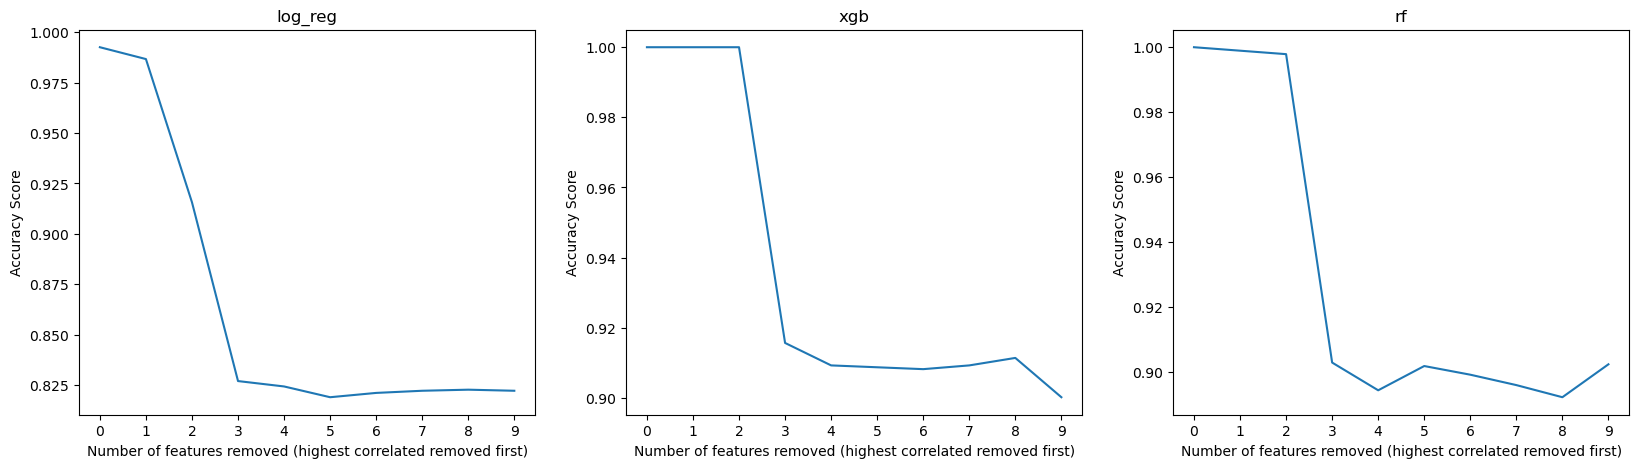

In [13]:
fix, axes = plt.subplots(1,3, figsize=(20,5))

for index, (name, result) in enumerate(model_results.items()): 
    sns.lineplot(data=result, ax=axes[index])
    axes[index].set_title(name)
    axes[index].set_xticks(range(len(result)))
    axes[index].set_xlabel("Number of features removed (highest correlated removed first)")
    axes[index].set_ylabel("Accuracy Score")

<Axes: >

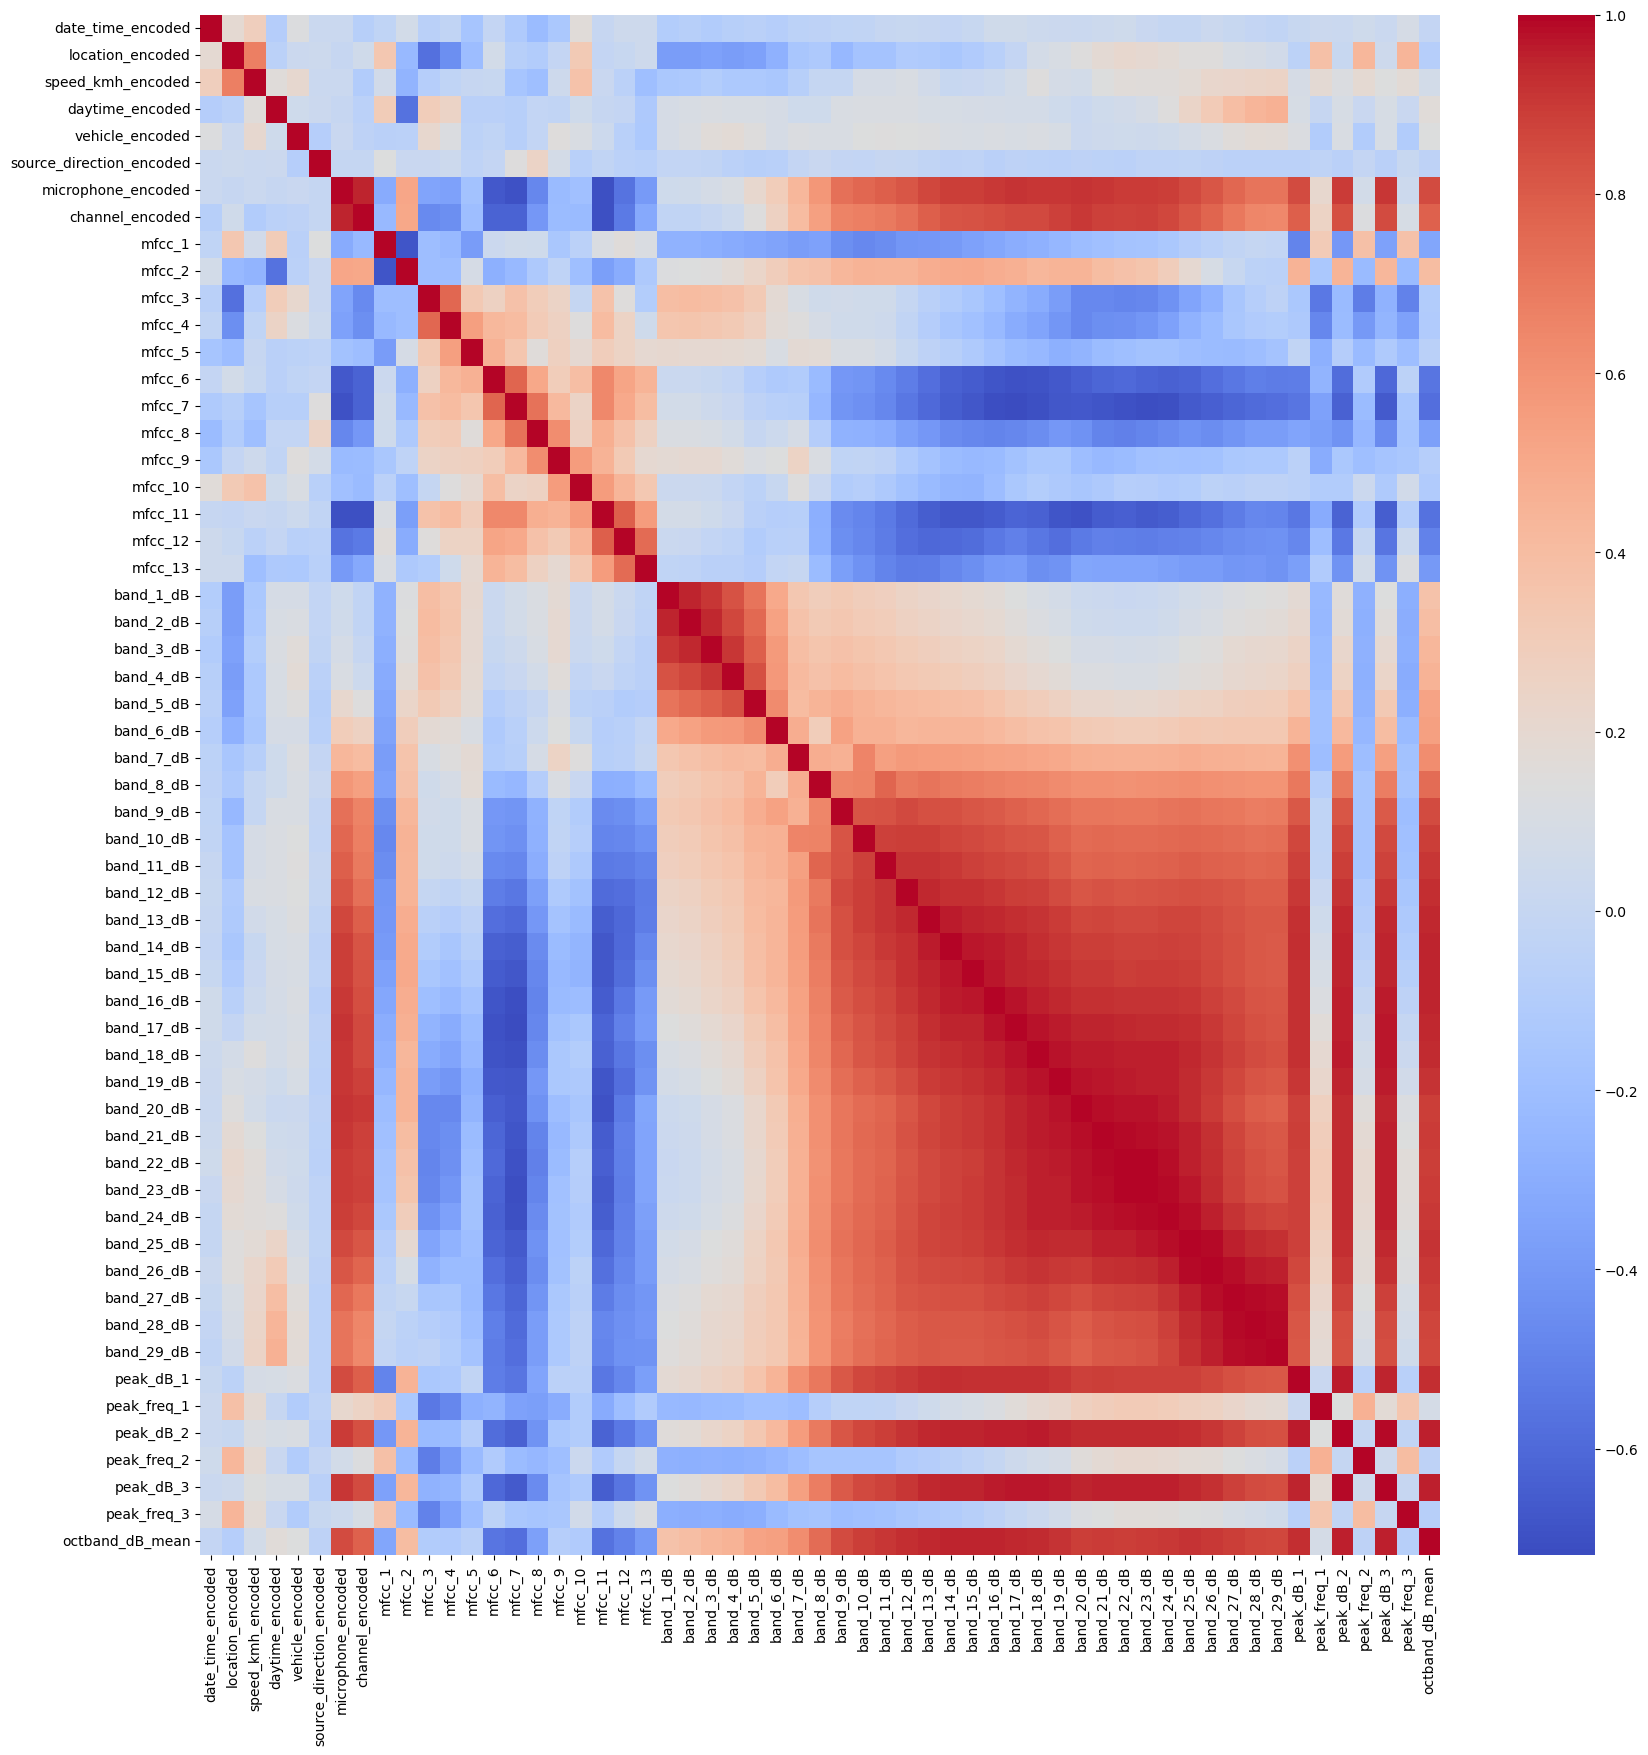

In [12]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(), cmap="coolwarm")

<H2>Model Training</h2>

In [ ]:
pipeline = Pipeline(
    [("scaler", MinMaxScaler()),
    ("smote", SMOTE(random_state=42)), 
    ("model", model)])

<h3>Logistic Regression </h3>

In [6]:
drop_log_reg = ranked_corr_weather[:2]

In [7]:
X_logreg = df.drop(columns=["weather_encoded"] + drop_log_reg )
y_logreg = df["weather_encoded"]

In [8]:
X_logreg.columns

Index(['date_time_encoded', 'daytime_encoded', 'vehicle_encoded',
       'source_direction_encoded', 'microphone_encoded', 'channel_encoded',
       'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
       'band_1_dB', 'band_2_dB', 'band_3_dB', 'band_4_dB', 'band_5_dB',
       'band_6_dB', 'band_7_dB', 'band_8_dB', 'band_9_dB', 'band_10_dB',
       'band_11_dB', 'band_12_dB', 'band_13_dB', 'band_14_dB', 'band_15_dB',
       'band_16_dB', 'band_17_dB', 'band_18_dB', 'band_19_dB', 'band_20_dB',
       'band_21_dB', 'band_22_dB', 'band_23_dB', 'band_24_dB', 'band_25_dB',
       'band_26_dB', 'band_27_dB', 'band_28_dB', 'band_29_dB', 'peak_dB_1',
       'peak_freq_1', 'peak_dB_2', 'peak_freq_2', 'peak_dB_3', 'peak_freq_3',
       'octband_dB_mean'],
      dtype='object')

In [9]:
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_logreg, y_logreg, test_size=0.2, random_state=42)

In [10]:
logreg = LogisticRegression() 
logreg.fit(X_train_logreg, y_train_logreg)
y_pred_logreg = logreg.predict(X_test_logreg)
print(classification_report(y_test_logreg, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1556
           1       0.81      0.78      0.79       317

    accuracy                           0.93      1873
   macro avg       0.88      0.87      0.88      1873
weighted avg       0.93      0.93      0.93      1873



/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Define pipeline for logreg 
pipeline_logreg = Pipeline(
    [("scaler", MinMaxScaler()),
    ("smote", SMOTE(random_state=42)), 
    ("logreg", LogisticRegression())])

In [15]:
# Define the parameter grid for grid search
param_grid = [
    {"logreg__C": [0.01, 0.1, 1, 10, 100, 1000], "logreg__penalty": ["l2"], "logreg__solver": ["lbfgs", "sag", "saga"]},
    {"logreg__C": [0.01, 0.1, 1, 10, 100, 1000], "logreg__penalty": ["none"], "logreg__solver": ["saga"]},
    {"logreg__C": [0.01, 0.1, 1, 10, 100, 1000], "logreg__penalty": ["l2"], "logreg__solver": ["liblinear"]},
]

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline_logreg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

# Fit GridSearchCV on training data
grid_search.fit(X_train_logreg, y_train_logreg)

# Print the best parameters and corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")
print(f"Average Cross-Validation Score: {grid_search.cv_results_['mean_test_score'].mean():.2f}")

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_logreg, y_train_logreg, cv=5, scoring='accuracy')

# Print the cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.2f}")

# Train and evaluate the model on the test data
best_model.fit(X_train_logreg, y_train_logreg)
y_pred_logreg = best_model.predict(X_test_logreg)
y_proba_logreg = best_model.predict_proba(X_test_logreg)

# Classification report
print("\nTest Set Evaluation:")
print(classification_report(y_test_logreg, y_pred_logreg))

/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Best Parameters: {'logreg__C': 1000, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validation Score: 0.93
Average Cross-Validation Score: 0.91
Cross-Validation Scores: [0.91655541 0.92923899 0.935247   0.93052772 0.92718771]
Mean CV Score: 0.93
Standard Deviation of CV Scores: 0.01

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1556
           1       0.71      0.92      0.80       317

    accuracy                           0.92      1873
   macro avg       0.84      0.92      0.88      1873
weighted avg       0.94      0.92      0.93      1873



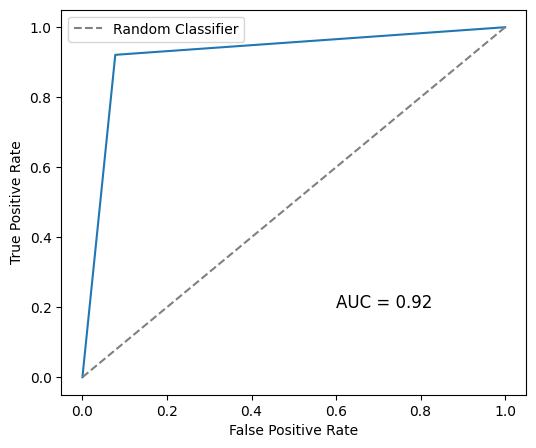

In [32]:
fpr, tpr, thresholds = roc_curve(y_test_logreg, y_pred_logreg)
roc_auc = roc_auc_score(y_test_logreg, y_pred_logreg)  

plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=plt.gca()) 


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

plt.text(0.6, 0.2, f'AUC = {roc_auc:.2f}', fontsize=12, color='black')

plt.legend()
plt.show()


In [33]:
confusion_matrix_logreg = confusion_matrix(y_test_logreg, y_pred_logreg)

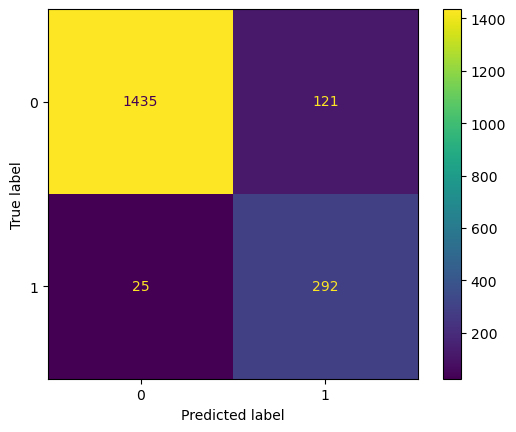

In [34]:
display_cm_logreg = ConfusionMatrixDisplay(confusion_matrix_logreg)
display_cm_logreg.plot()
plt.show()

<h3>XGBoost </h3>

In [35]:
drop_xgb = ranked_corr_weather[:3]

In [36]:
X_xgb = df.drop(columns=["weather_encoded"] + drop_xgb )
y_xgb = df["weather_encoded"]

In [37]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

In [38]:
#Model without any parameter tuning
xgb = XGBClassifier() 

xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb.predict(X_test_xgb)
print(classification_report(y_test_xgb, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1556
           1       0.79      0.67      0.72       317

    accuracy                           0.91      1873
   macro avg       0.86      0.82      0.84      1873
weighted avg       0.91      0.91      0.91      1873



Hyperparameter Tuning with SMOTE

In [39]:
# Define pipeline for XGBoost with SMOTE 
pipeline_xgb = Pipeline(
    [("scaler", MinMaxScaler()),
    ("smote", SMOTE(random_state=42)), 
    ("xgb", XGBClassifier())])

In [40]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)
# Define the parameter grid for GridSearchCV
param_grid = {
    "xgb__max_depth": [3, 5, 7],            
    "xgb__learning_rate": [0.01, 0.1, 0.2], 
    "xgb__n_estimators": [50, 100, 200],    
    "xgb__subsample": [0.8, 1.0],         
    "xgb__colsample_bytree": [0.8, 1.0],   
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)

# Fit GridSearchCV on training data
grid_search.fit(X_train_xgb, y_train_xgb)

# Print the best parameters and corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")
print(f"Average Cross-Validation Score: {grid_search.cv_results_['mean_test_score'].mean():.2f}")

# Extract the best model from grid search
best_model = grid_search.best_estimator_

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_xgb, y_train_xgb, cv=5, scoring='accuracy')

# Print the cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.2f}")

# Train and evaluate the model on the test data
best_model.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = best_model.predict(X_test_xgb)

# Classification report
print("\nTest Set Evaluation:")
print(classification_report(y_test_xgb, y_pred_xgb))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=0.8; total time=   0.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=0.8; total time=   0.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=1.0; total time=   0.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=1.0; total time=   0.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=0.8; total time=   0.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=0.8; total time=   0.3s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=

In [41]:
confusion_matrix_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)

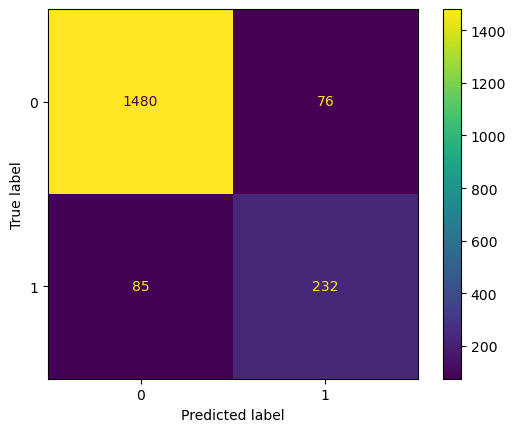

In [42]:
display_cm_xgb = ConfusionMatrixDisplay(confusion_matrix_xgb)
display_cm_xgb.plot()
plt.show()

Hyperparameter Tuning with Class Weithts

In [43]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_xgb),
    y=y_train_xgb
)
scale_pos_weight = class_weights[0] / class_weights[1]

In [44]:
# Definde pipeline for XGBoost without SMOTE 
pipeline_xgb_weights = Pipeline(
    [("scaler", MinMaxScaler()),
    ("xgb", XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42))])

In [45]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "xgb__max_depth": [3, 5, 7],            
    "xgb__learning_rate": [0.01, 0.1, 0.2], 
    "xgb__n_estimators": [50, 100, 200],    
    "xgb__subsample": [0.8, 1.0],         
    "xgb__colsample_bytree": [0.8, 1.0],   
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline_xgb_weights, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)

# Fit GridSearchCV on training data
grid_search.fit(X_train_xgb, y_train_xgb)

# Print the best parameters and corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")

# Extract the best model from grid search
best_model = grid_search.best_estimator_

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_xgb, y_train_xgb, cv=5, scoring='accuracy')

# Print the cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.2f}")

# Train and evaluate the model on the test data
best_model.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = best_model.predict(X_test_xgb)

# Classification report
print("\nTest Set Evaluation:")
print(classification_report(y_test_xgb, y_pred_xgb))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=0.8; total time=   0.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=1.0; total time=   0.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=0.8; total time=   0.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=0.8; total time=   0.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=0.8; total time=   0.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50, xgb__subsample=0.8; total time=   0.2s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=

In [46]:
confusion_matrix_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)

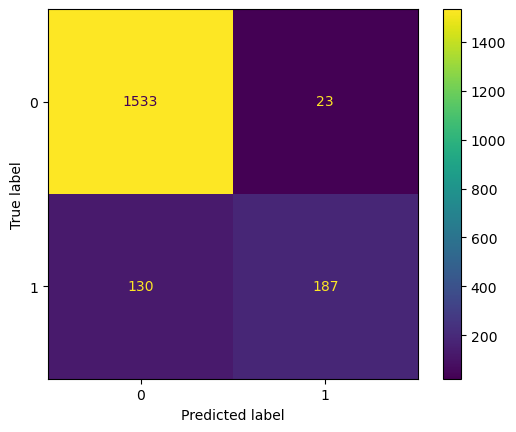

In [47]:
display_cm_xgb = ConfusionMatrixDisplay(confusion_matrix_xgb)
display_cm_xgb.plot()
plt.show()

<h3> RandomForestClassifier </h3>

In [13]:
drop_rf = ranked_corr_weather[:3]

In [14]:
X_rf = df.drop(columns=["weather_encoded"] + drop_rf )
y_rf = df["weather_encoded"]

In [15]:
# define pipeline for random forest 
pipeline_rf = Pipeline(
    [("scaler", MinMaxScaler()),
    ("smote", SMOTE(random_state=42)), 
    ("rf", RandomForestClassifier())])

In [16]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)
print(classification_report(y_test_rf, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1556
           1       0.86      0.56      0.68       317

    accuracy                           0.91      1873
   macro avg       0.89      0.77      0.81      1873
weighted avg       0.91      0.91      0.90      1873



Hyperparamter tuning with SMOTE 

In [22]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "rf__n_estimators": [100, 200, 300],         
    "rf__max_depth": [None, 10, 20, 30],        
    "rf__min_samples_split": [2, 5, 10],        
    "rf__min_samples_leaf": [1, 2, 4],          
    "rf__bootstrap": [True, False],            
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)

# Fit GridSearchCV on training data
grid_search_rf.fit(X_train_rf, y_train_rf)

# Print the best parameters and corresponding score
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Best Cross-Validation Score: {grid_search_rf.best_score_:.2f}")

# Evaluate the best model on the test data
best_model = grid_search_rf.best_estimator_

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train_rf, y_train_rf, cv=5, scoring='accuracy')

# Print the cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.2f}")

# Train and evaluate the model on the test data
best_model.fit(X_train_rf, y_train_rf)
y_pred_rf = best_model.predict(X_test_rf)

# Classification report
print("\nTest Set Evaluation:")
print(classification_report(y_test_rf, y_pred_rf))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   5.4s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   5.6s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   5.6s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   5.7s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   5.8s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=  11.1s
[CV] END rf__bootstrap=True, rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__

In [23]:
confusion_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)
confusion_matrix_rf

array([[1479,   77],
       [  96,  221]])

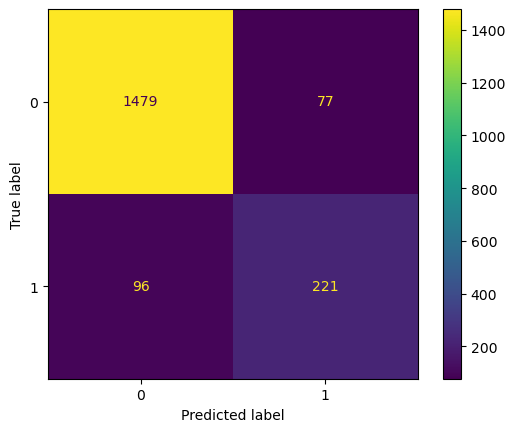

In [24]:
display_cm_rf = ConfusionMatrixDisplay(confusion_matrix_rf)
display_cm_rf.plot()
plt.show()

<h2>Backup: Data Leakage </h2>

The following code was used to find out why all models perform that well using all features (except target)

In [68]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# PCA Setup
pca = PCA()

# SMOTE + Scaling + PCA + Logistic Regression Pipeline
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('logreg', LogisticRegression(max_iter=500, random_state=42))
])

# Parameter Grid for GridSearchCV
param_grid_lr_pca = {
    'pca__n_components': [0.95, 0.99],  # Explained variance thresholds
    'logreg__C': [0.01, 0.1, 1, 10],    # Regularization strength
    'logreg__solver': ['lbfgs', 'saga'], 
    'logreg__multi_class': ['multinomial'],
    'logreg__class_weight': ['balanced']
}

# Hyperparameter Tuning with GridSearchCV
grid_search_lr_pca = GridSearchCV(
    pipeline,
    param_grid_lr_pca,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

# Fit the pipeline
grid_search_lr_pca.fit(X_train_scaled, y_train)

# Best Estimator
best_lr_pca = grid_search_lr_pca.best_estimator_
print("Best Parameters with PCA:", grid_search_lr_pca.best_params_)

# Evaluate on Test Data
y_pred_lr_pca = best_lr_pca.predict(X_test_scaled)
print("Evaluation with PCA:")
print(classification_report(y_test, y_pred_lr_pca))

# Standard Logistic Regression without PCA for Comparison
standard_logreg.fit(X_train_scaled, y_train)
y_pred_standard_logreg = standard_logreg.predict(X_test_scaled)
print("Evaluation without PCA:")
print(classification_report(y_test, y_pred_standard_logreg))


Best Parameters with PCA: {'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__multi_class': 'multinomial', 'logreg__solver': 'lbfgs', 'pca__n_components': 0.99}
Evaluation with PCA:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1556
           1       0.47      0.82      0.60       317

    accuracy                           0.81      1873
   macro avg       0.71      0.82      0.74      1873
weighted avg       0.87      0.81      0.83      1873

Evaluation without PCA:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      1556
           1       0.48      0.85      0.62       317

    accuracy                           0.82      1873
   macro avg       0.72      0.83      0.75      1873
weighted avg       0.88      0.82      0.84      1873



In [67]:

param_grid_xgb = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],  
    'reg_lambda': [1, 10, 50, 100]  
}

random_search_xgb = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, random_state=42),
    param_distributions=param_grid_xgb,
    n_iter=50, 
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_scaled, y_train)

# Best XGBoost Model
best_xgb = random_search_xgb.best_estimator_
print("Best Parameters for XGBoost:", random_search_xgb.best_params_)

# Fit and Evaluate
y_pred_xgb = best_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_xgb))

standard_xgb = XGBClassifier()

standard_xgb.fit(X_train_scaled, y_train)
y_pred_standard_xgb = standard_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_standard_xgb))



/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

Best Parameters for XGBoost: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1556
           1       0.74      0.73      0.73       317

    accuracy                           0.91      1873
   macro avg       0.84      0.84      0.84      1873
weighted avg       0.91      0.91      0.91      1873

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1556
           1       0.72      0.71      0.71       317

    accuracy                           0.90      1873
   macro avg       0.83      0.83      0.83      1873
weighted avg       0.90      0.90      0.90      1873



In [26]:
best_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

best_rf.fit(X_train_scaled, y_train)

y_pred = best_rf.predict(X_test_scaled)


standard_rf = RandomForestClassifier()

standard_rf.fit(X_train_scaled, y_train)
y_pred_standard_rf = standard_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_standard_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1556
           1       1.00      1.00      1.00       317

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873



In [27]:
# Add noise to the test data
noise_level = 0.05  
X_test_noisy = X_test_scaled.copy()


std_devs = np.std(X_test_scaled, axis=0) 
noise = np.random.normal(0, noise_level * std_devs, X_test_scaled.shape) 
X_test_noisy += noise  

In [28]:
models = {
    "Best Logistic Regression": best_lr,
    "Standard Logistic Regression": standard_logreg, 
    "Best XGBoost": best_xgb,
    "Standard XGBoost": standard_xgb,
    "Best Random Forest": best_rf,
    "Standard Random Forest": standard_rf
}

for name, model in models.items():
    print(50*"-")
    print(name)
    print(50*"-")
    print(f"Evaluating {name} on test data...")
    y_pred= model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    print(50*"-")
    print(f"Evaluating {name} on noisy test data...")
    y_pred_noisy = model.predict(X_test_noisy)
    print(classification_report(y_test, y_pred_noisy))


--------------------------------------------------
Best Logistic Regression
--------------------------------------------------
Evaluating Best Logistic Regression on test data...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1556
           1       1.00      1.00      1.00       317

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

--------------------------------------------------
Evaluating Best Logistic Regression on noisy test data...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1556
           1       0.99      1.00      1.00       317

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

--------------------------------------------------
Standar

In [4]:
y = df["daytime_encoded"]
df = df.drop(columns=["daytime_encoded"]) 

In [5]:

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('classifier', LogisticRegression(solver='liblinear')) 
])

features = list(df.columns)

for n_features in range(len(features)): 
    f = features[:(n_features+1)]
    X = df[f]
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(60*"-")
    print(f"Features used: {features[0:(n_features+1)]}")
    print(60*"-")
    print(classification_report(y_test, y_pred))

------------------------------------------------------------
Features used: ['date_time_encoded']
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.96      0.74      1116
           1       0.56      0.08      0.13       757

    accuracy                           0.60      1873
   macro avg       0.58      0.52      0.44      1873
weighted avg       0.59      0.60      0.50      1873

------------------------------------------------------------
Features used: ['date_time_encoded', 'location_encoded']
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.86      0.69      1062
           1       0.47      0.16      0.23       811

    accuracy                           0.56      1873
   macro avg       0.52      0.51      0.46      1873
weighted avg       0.53      0.56      0.49      1873

--------